In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.cmlp_container import CMLP_Container
import pickle
import seaborn as sns
import yaml

### Endogenous VAR Data

In [2]:
config = {
    "data_dir": "../data",
    "yaml_path": "../configs/train_cmlp_endo.yaml",
    "model_save_dir": "./saved_models",
    "catagory": "endogenous",
}
cmlp_container = CMLP_Container(eval_config=config)

endogenous data loaded...


True variable usage = 6.56%
Estimated variable usage = 11.44%
Accuracy = 90.00%
------------------------------------------------------------------------
Type-k       TPR            TNR        MAEE      MAFE(train)    MAFE(val)
        endo     exo   endo     exo
------------------------------------------------------------------------
IGLS:
A-30    0.539     -    0.658     -     0.049       0.239          0.304
B-30    0.390   0.446  0.836   0.761   0.027       0.363          0.423
------------------------------------------------------------------------
CE Optim-IGLS
A-30    0.531     -    0.696     -     0.067       0.211          0.322
B-30    0.417   0.444  0.871   0.830   0.032       0.232          0.330
------------------------------------------------------------------------
Neural GC
A-30    0.610     -    0.920     -     0.012       0.081          0.082
------------------------------------------------------------------------


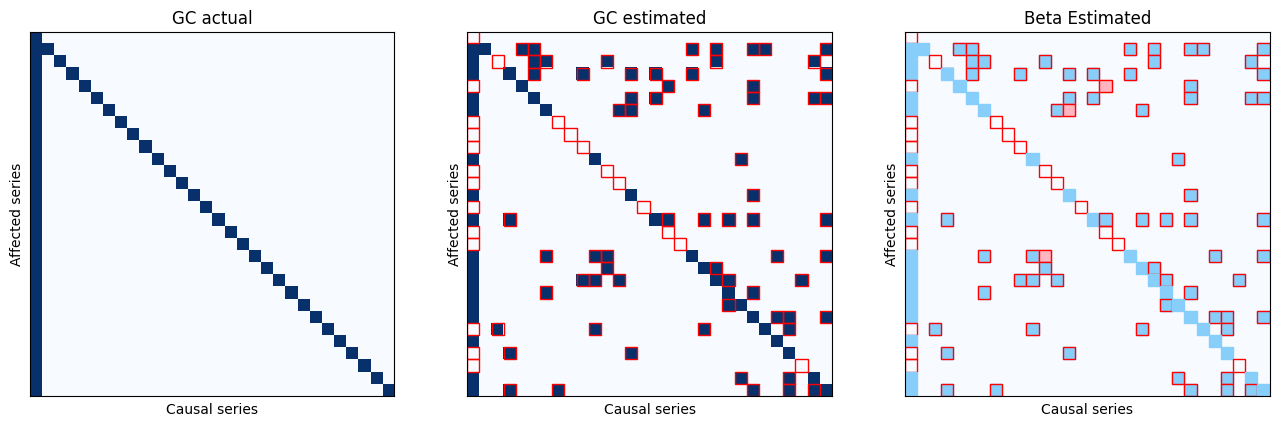

In [3]:
# Verify learned Granger causality
GC = cmlp_container.GC
GC_est = cmlp_container.cmlp.GC().cpu().data.numpy()
Beta_est = cmlp_container.cmlp.GC(threshold=False, prime=True).cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

cmlp_container.evaluate()

# Make figures
fig, axarr = plt.subplots(1, 3, figsize=(16, 10))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

axarr[2].imshow(Beta_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(Beta_est), len(Beta_est), 0))
axarr[2].set_title(f'Beta Estimated')
axarr[2].set_ylabel('Affected series')
axarr[2].set_xlabel('Causal series')
axarr[2].set_xticks([])
axarr[2].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

for i in range(len(Beta_est)):
    for j in range(len(Beta_est)):
        if Beta_est[i, j] < 0:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='lightpink', edgecolor='lightpink', linewidth=1)
            axarr[2].add_patch(rect)
        if Beta_est[i, j] > 0:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='lightskyblue', edgecolor='lightskyblue', linewidth=1)
            axarr[2].add_patch(rect)
        if (Beta_est[i, j] == 0 and GC[i, j] != 0) or (Beta_est[i, j] != 0 and GC[i, j] == 0):
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[2].add_patch(rect)
plt.show()

In [4]:
with open(f'{config["model_save_dir"]}/cmlp_{config["catagory"]}_loss.pickle', 'rb') as f:
    train_loss_list = pickle.load(f)
for i in range(len(train_loss_list)):
    train_loss_list[i] = train_loss_list[i].cpu().numpy()

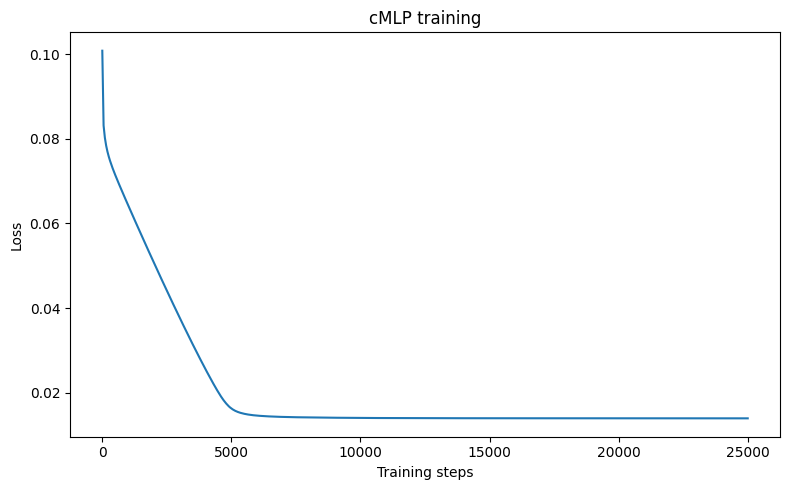

In [5]:
# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

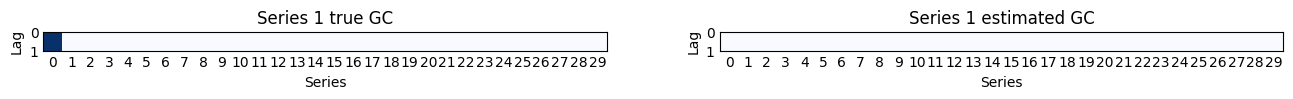

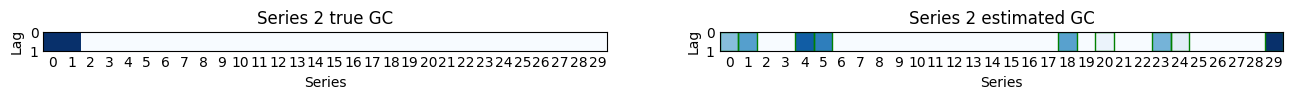

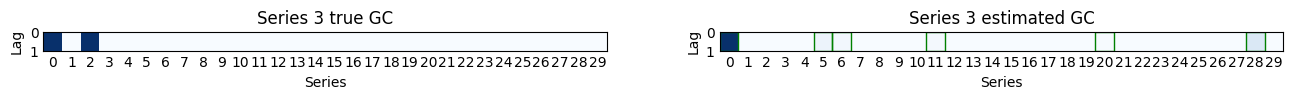

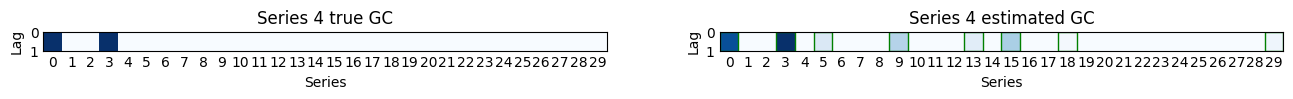

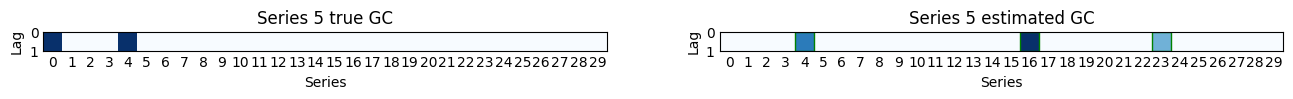

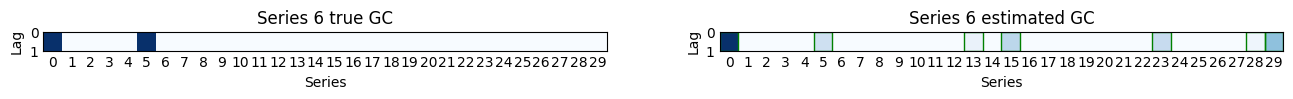

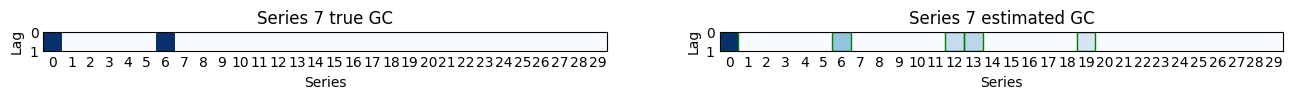

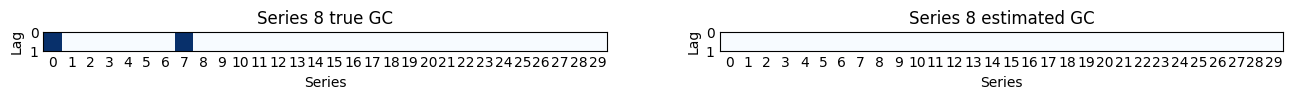

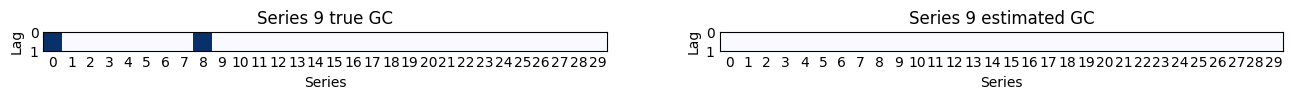

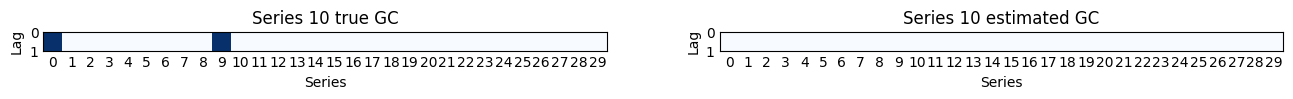

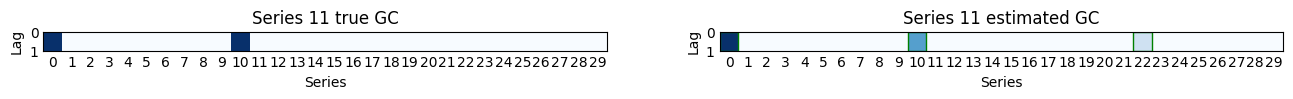

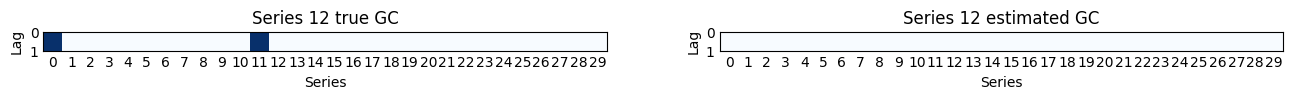

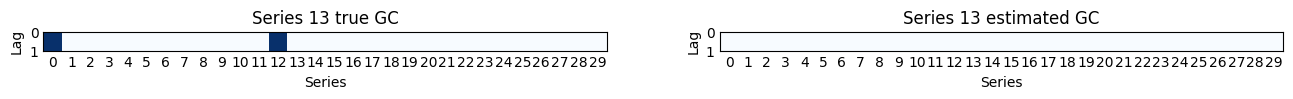

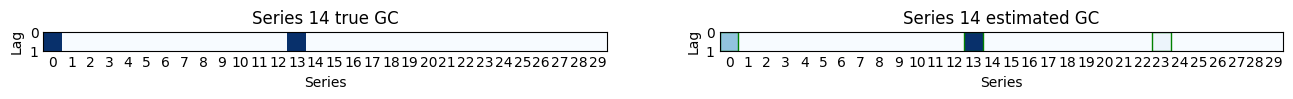

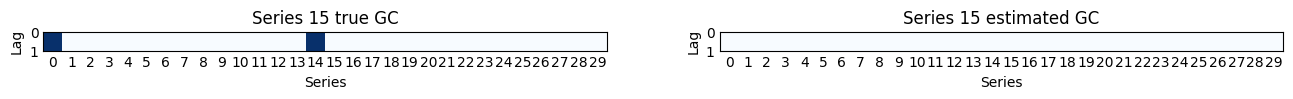

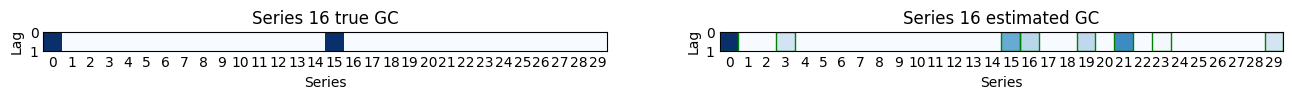

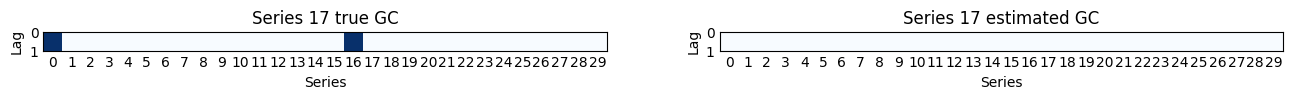

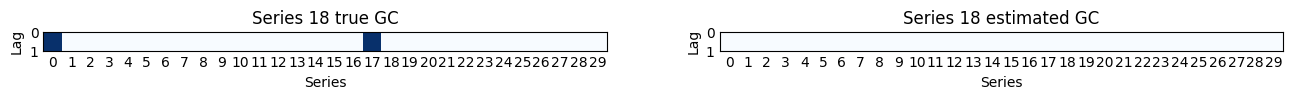

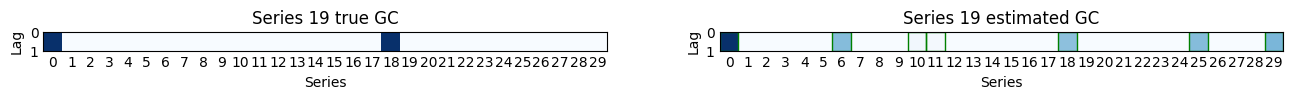

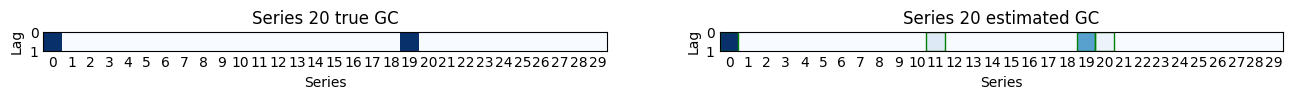

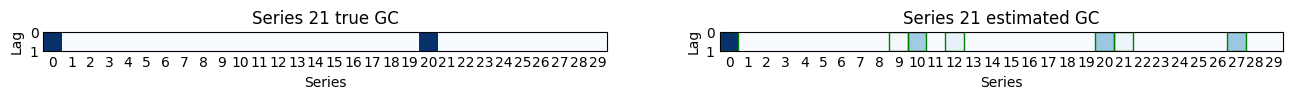

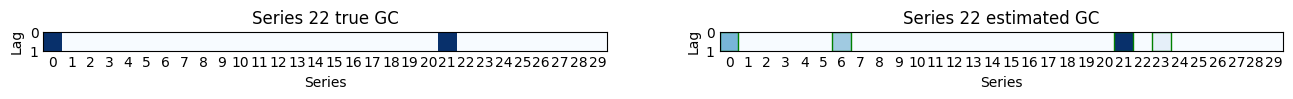

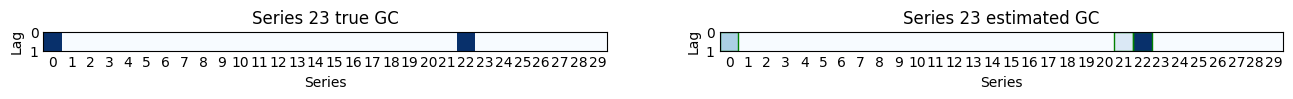

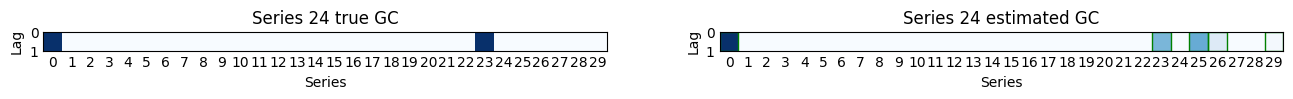

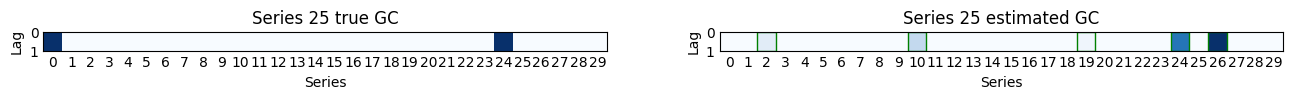

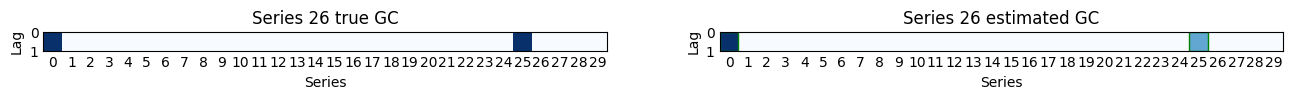

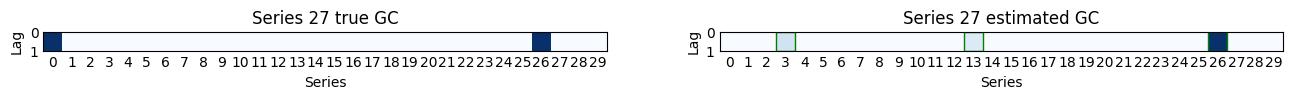

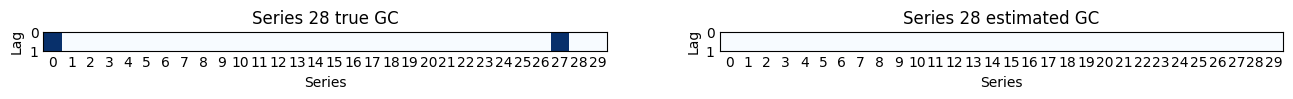

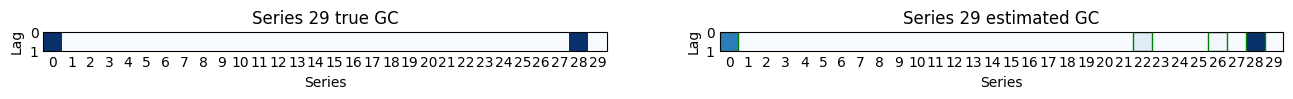

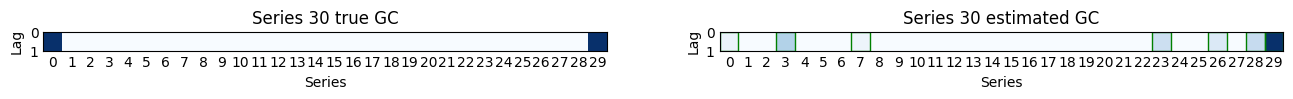

In [6]:
cmlp = cmlp_container.cmlp
lag = cmlp.lag
for i in range(len(GC_est)):
    # Get true GC
    GC_lag = np.zeros((lag, len(GC_est)))
    GC_lag[:lag, GC[i].astype(bool)] = 1.0

    # Get estimated GC
    GC_est_lag = cmlp.GC(ignore_lag=False, threshold=False)[i].cpu().data.numpy().T[::-1]

    # Make figures
    fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
    axarr[0].imshow(GC_lag, cmap='Blues', extent=(0, len(GC_est), lag, 0))
    axarr[0].set_title('Series %d true GC' % (i + 1))
    axarr[0].set_ylabel('Lag')
    axarr[0].set_xlabel('Series')
    axarr[0].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[0].set_xticklabels(range(len(GC_est)))
    # axarr[0].set_yticks(np.arange(5) + 0.5)
    # axarr[0].set_yticklabels(range(1, 5 + 1))
    axarr[0].tick_params(axis='both', length=0)

    axarr[1].imshow(GC_est_lag, cmap='Blues', extent=(0, len(GC_est), lag, 0))
    axarr[1].set_title('Series %d estimated GC' % (i + 1))
    axarr[1].set_ylabel('Lag')
    axarr[1].set_xlabel('Series')
    axarr[1].set_xticks(np.arange(len(GC_est)) + 0.5)
    axarr[1].set_xticklabels(range(len(GC_est)))
    # axarr[1].set_yticks(np.arange(5) + 0.5)
    # axarr[1].set_yticklabels(range(1, 5 + 1))
    axarr[1].tick_params(axis='both', length=0)

    # Mark nonzeros
    for i in range(len(GC_est)):
        for j in range(1):
            if GC_est_lag[j, i] > 0.0:
                rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='green', linewidth=1.0)
                axarr[1].add_patch(rect)
            if GC_est_lag[j, i] < 0.0:
                rect = plt.Rectangle((i, j), 1, 1, facecolor='none', edgecolor='red', linewidth=1.0)
                axarr[1].add_patch(rect)
    plt.show()

### Exogenous Data

In [7]:
composed_config = {
    "data_dir": "../data",
    "yaml_path": "../configs/train_cmlp.yaml",
    "model_save_dir": "./saved_models",
    "catagory": "latent",
}
composed_cmlp_container = CMLP_Container(eval_config=composed_config)

latent data loaded...


Beta:
True variable usage = 6.56%
Estimated variable usage = 14.11%
Accuracy = 88.44%
Alpha:
True variable usage = 6.56%
Estimated variable usage = 4.56%
Accuracy = 89.33%
------------------------------------------------------------------------
Type-k       TPR            TNR        MAEE      MAFE(train)    MAFE(val)
        endo     exo   endo     exo
------------------------------------------------------------------------
IGLS:
A-30    0.539     -    0.658     -     0.049       0.239          0.304
B-30    0.390   0.446  0.836   0.761   0.027       0.363          0.423
------------------------------------------------------------------------
CE Optim-IGLS
A-30    0.531     -    0.696     -     0.067       0.211          0.322
B-30    0.417   0.444  0.871   0.830   0.032       0.232          0.330
------------------------------------------------------------------------
Neural GC
B-30    0.695   0.034  0.898   0.954   0.054       0.388          0.396
------------------------------------

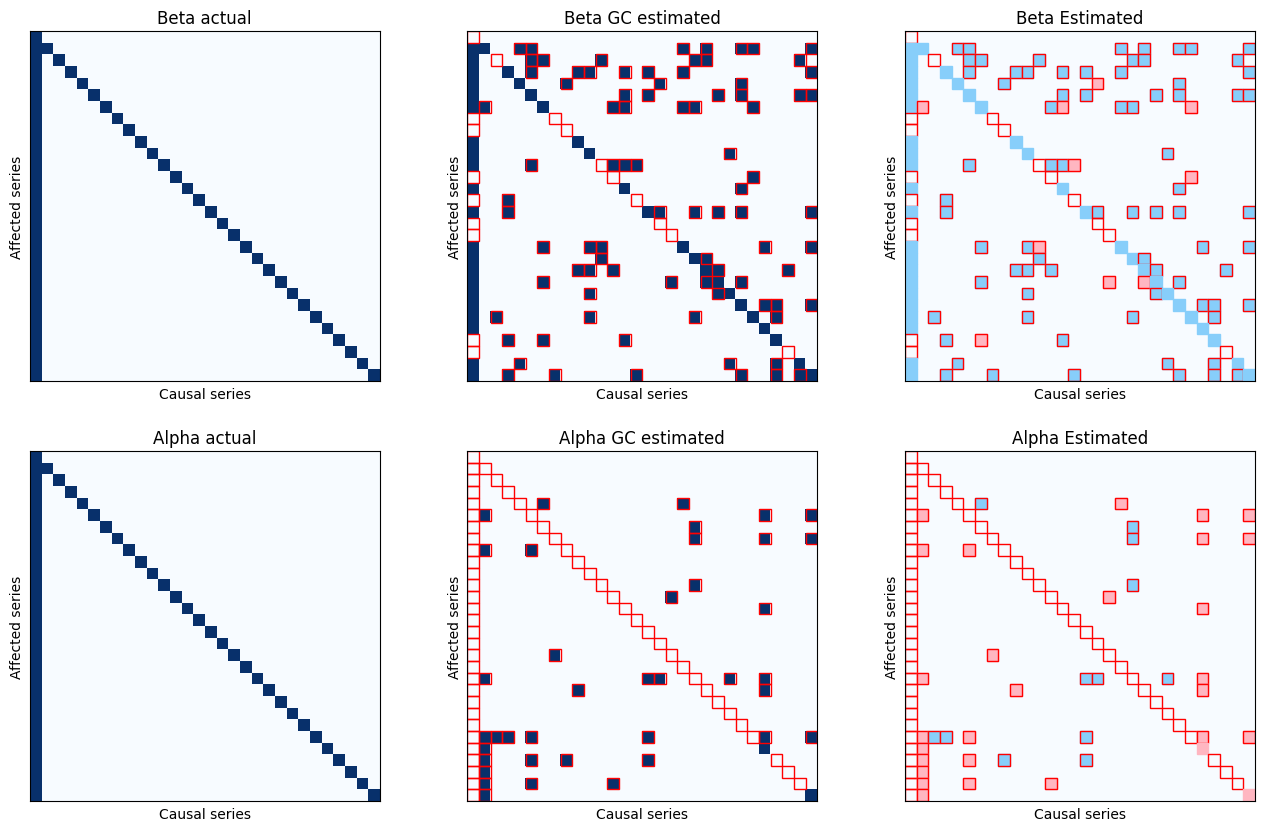

In [15]:
# Verify learned Granger causality
Alpha = composed_cmlp_container.data['alpha']
Beta = composed_cmlp_container.data['beta']
GCs_est = composed_cmlp_container.cmlp.GC()
Beta_est = composed_cmlp_container.cmlp.cmlps[0].GC(threshold=False, prime=True).cpu().data.numpy()
Alpha_est = composed_cmlp_container.cmlp.cmlps[1].GC(threshold=False, prime=True).cpu().data.numpy()

for i in range(len(GCs_est[0])):
    for j in range(len(GCs_est[0])):
        Beta[i, j] = 1 if Beta[i, j] != 0 else 0
        Alpha[i, j] = 1 if Alpha[i, j] != 0 else 0
        
print('Beta:')
print('True variable usage = %.2f%%' % (100 * np.mean(Beta)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GCs_est[0])))
print('Accuracy = %.2f%%' % (100 * np.mean(Beta == GCs_est[0])))
print('Alpha:')
print('True variable usage = %.2f%%' % (100 * np.mean(Alpha)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GCs_est[1])))
print('Accuracy = %.2f%%' % (100 * np.mean(Alpha == GCs_est[1])))

composed_cmlp_container.evaluate()

# Make figures
fig, axarr = plt.subplots(2, 3, figsize=(16, 10))
axarr[0][0].imshow(Beta, cmap='Blues')
axarr[0][0].set_title('Beta actual')
axarr[0][0].set_ylabel('Affected series')
axarr[0][0].set_xlabel('Causal series')
axarr[0][0].set_xticks([])
axarr[0][0].set_yticks([])

axarr[0][1].imshow(GCs_est[0], cmap='Blues', vmin=0, vmax=1, extent=(0, len(GCs_est[0]), len(GCs_est[0]), 0))
axarr[0][1].set_title('Beta GC estimated')
axarr[0][1].set_ylabel('Affected series')
axarr[0][1].set_xlabel('Causal series')
axarr[0][1].set_xticks([])
axarr[0][1].set_yticks([])

axarr[0][2].imshow(Beta_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(Beta_est), len(Beta_est), 0))
axarr[0][2].set_title(f'Beta Estimated')
axarr[0][2].set_ylabel('Affected series')
axarr[0][2].set_xlabel('Causal series')
axarr[0][2].set_xticks([])
axarr[0][2].set_yticks([])

axarr[1][0].imshow(Alpha, cmap='Blues')
axarr[1][0].set_title('Alpha actual')
axarr[1][0].set_ylabel('Affected series')
axarr[1][0].set_xlabel('Causal series')
axarr[1][0].set_xticks([])
axarr[1][0].set_yticks([])

axarr[1][1].imshow(GCs_est[1], cmap='Blues', vmin=0, vmax=1, extent=(0, len(GCs_est[1]), len(GCs_est[1]), 0))
axarr[1][1].set_title('Alpha GC estimated')
axarr[1][1].set_ylabel('Affected series')
axarr[1][1].set_xlabel('Causal series')
axarr[1][1].set_xticks([])
axarr[1][1].set_yticks([])

axarr[1][2].imshow(Alpha_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(Alpha_est), len(Alpha_est), 0))
axarr[1][2].set_title(f'Alpha Estimated')
axarr[1][2].set_ylabel('Affected series')
axarr[1][2].set_xlabel('Causal series')
axarr[1][2].set_xticks([])
axarr[1][2].set_yticks([])

# Mark disagreements
for i in range(len(GCs_est[0])):
    for j in range(len(GCs_est[0])):
        Beta[i, j] = 1 if Beta[i, j] != 0 else 0
        if Beta[i, j] != GCs_est[0][i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[0][1].add_patch(rect)

for i in range(len(Beta_est)):
    for j in range(len(Beta_est)):
        if Beta_est[i, j] < 0:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='lightpink', edgecolor='lightpink', linewidth=1)
            axarr[0][2].add_patch(rect)
        if Beta_est[i, j] > 0:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='lightskyblue', edgecolor='lightskyblue', linewidth=1)
            axarr[0][2].add_patch(rect)
        if (Beta_est[i, j] == 0 and Beta[i, j] != 0) or (Beta_est[i, j] != 0 and Beta[i, j] == 0):
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[0][2].add_patch(rect)

for i in range(len(GCs_est[1])):
    for j in range(len(GCs_est[1])):
        Alpha[i, j] = 1 if Alpha[i, j] != 0 else 0
        if Beta[i, j] != GCs_est[1][i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1][1].add_patch(rect)

for i in range(len(Alpha_est)):
    for j in range(len(Alpha_est)):
        if Alpha_est[i, j] < 0:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='lightpink', edgecolor='lightpink', linewidth=1)
            axarr[1][2].add_patch(rect)
        if Alpha_est[i, j] > 0:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='lightskyblue', edgecolor='lightskyblue', linewidth=1)
            axarr[1][2].add_patch(rect)
        if (Alpha_est[i, j] == 0 and Alpha[i, j] != 0) or (Alpha_est[i, j] != 0 and Alpha[i, j] == 0):
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1][2].add_patch(rect)
plt.show()
plt.show()

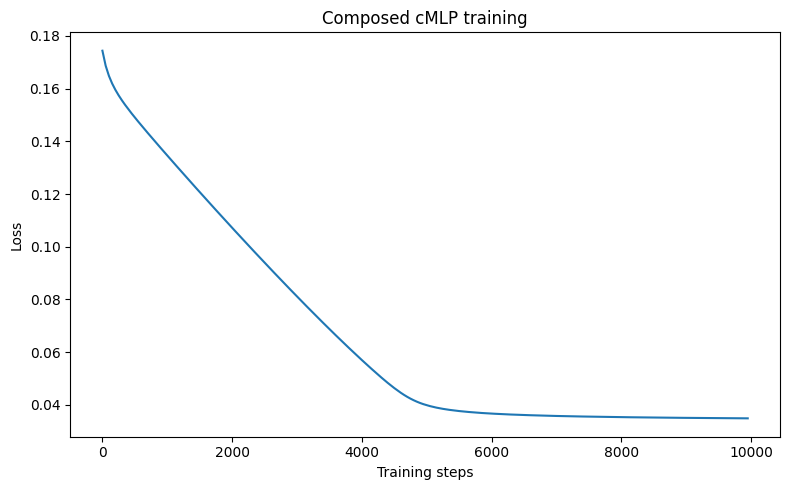

In [ ]:
with open(f'{composed_config["model_save_dir"]}/cmlp_{composed_config["catagory"]}_loss.pickle', 'rb') as f:
    train_loss_list = pickle.load(f)
for i in range(len(train_loss_list)):
    train_loss_list[i] = train_loss_list[i].cpu().numpy()
# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('Composed cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()